In [1]:
%pip install Sastrawi
import nltk
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

import pandas as pd
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import re
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from transformers import TFBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.preprocessing import LabelEncoder

label_type = ['ham', 'spam']

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.1 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  infla

2024-06-09 17:27:42.129948: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 17:27:42.130042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 17:27:42.274219: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_csv('/kaggle/input/spam-dataset-indo/spam_dataset_indo.csv')
data['Pesan'] = data['Pesan'].astype(str)
texts = data['Pesan'].values
labels = data['Kategori'].values

In [4]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
stopwords += custom_stopwords

pattern = r"[^A-Za-z ]"

lemmatizer = WordNetLemmatizer()

def preprocess_text(texts):
    for index, text in enumerate(texts):
        text = text.lower()

        text = re.sub(pattern, '', text)

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in stopwords]

        word_list = [lemmatizer.lemmatize(word) for word in word_list]

        text = ' '.join(word_list)
        texts[index] = text
    return texts

In [5]:
texts = preprocess_text(texts)

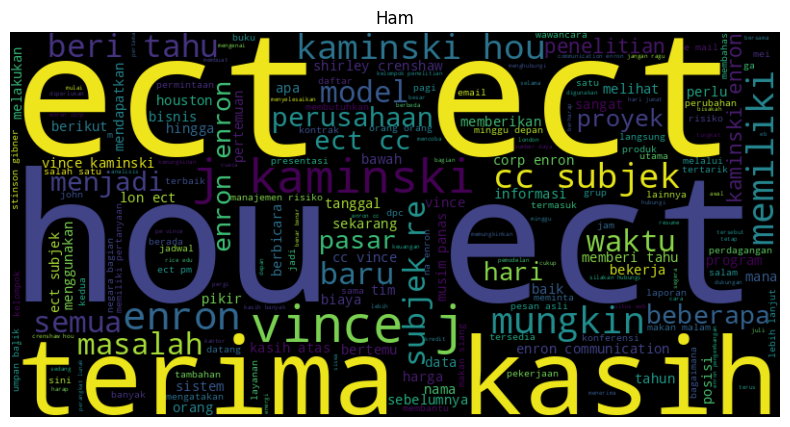

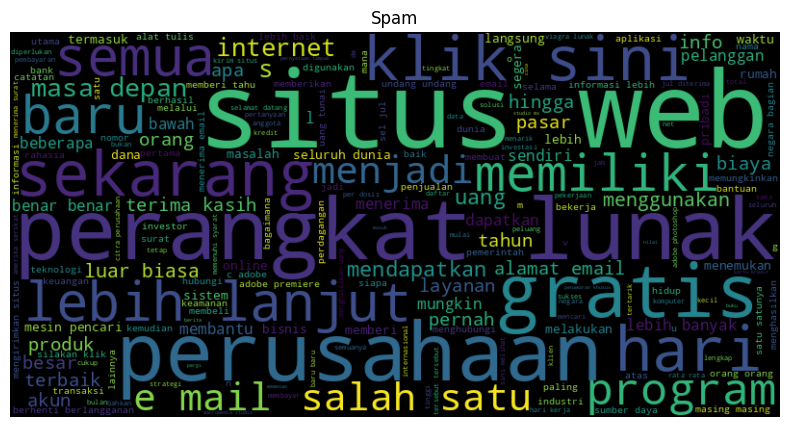

In [6]:
def generate_wordcloud(text,Title):
    all_text = "".join(str(text))
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()
    
ham = texts[labels=='ham'].tolist()
generate_wordcloud(ham,'Ham')

spam = texts[labels=='spam'].tolist()
generate_wordcloud(spam,'Spam')

In [7]:
train_texts, tests_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2)

In [8]:
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')

def tokenize_function(texts):
    return tokenizer(texts,padding=True,truncation=True, return_tensors='tf', max_length=512)

train_encodings = tokenize_function(train_texts.tolist())
test_encodings = tokenize_function(tests_texts.tolist())


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

In [9]:
le = LabelEncoder()

train_labels = le.fit_transform(train_labels)
test_labels = le.fit_transform(test_labels)

In [10]:
model = TFBertForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', num_labels=2, from_pt=True)


pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
epochs = 2
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [12]:
history = model.fit(
    [train_encodings['input_ids'], train_encodings['token_type_ids'], train_encodings['attention_mask']],
    train_labels, validation_split = 0.1,
    batch_size=16,
    epochs=epochs
)

Epoch 1/2
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1717954250.244584     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


170/170 [==============================] - 284s 1s/step - loss: 0.2333 - accuracy: 0.9062 - val_loss: 0.1076 - val_accuracy: 0.9571
Epoch 2/2
170/170 [==============================] - 184s 1s/step - loss: 0.0576 - accuracy: 0.9816 - val_loss: 0.0826 - val_accuracy: 0.9769


24/24 [==============================] - 27s 665ms/step
Accuracy Score: 0.9708994708994709
Recall Score: 0.9868766404199475
Precision Score: 0.9567430025445293
F1 Score: 0.9715762273901809
Classification Report:               precision    recall  f1-score   support

         ham       0.95      0.99      0.97       363
        spam       0.99      0.96      0.97       393

    accuracy                           0.97       756
   macro avg       0.97      0.97      0.97       756
weighted avg       0.97      0.97      0.97       756

Confusion Matrix:



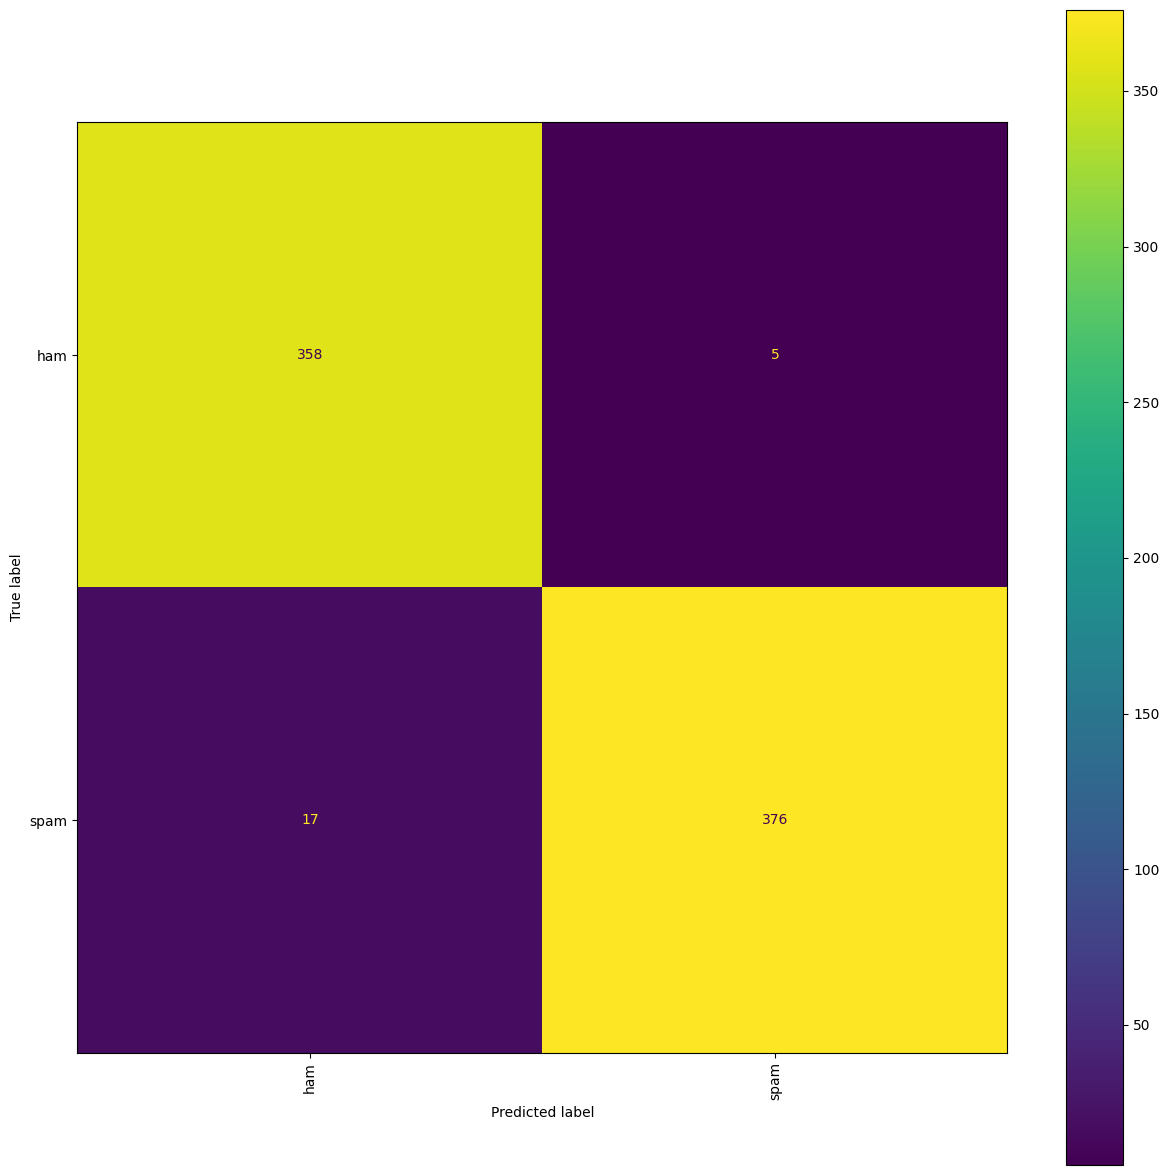

In [13]:
pred = model.predict([test_encodings['input_ids'], test_encodings['token_type_ids'], test_encodings['attention_mask']])
pred_labels = tf.argmax(pred.logits, axis=1)

print(f"Accuracy Score: {accuracy_score(pred_labels, test_labels)}")
print(f"Recall Score: {recall_score(pred_labels, test_labels)}")
print(f"Precision Score: {precision_score(pred_labels, test_labels)}")
print(f"F1 Score: {f1_score(pred_labels, test_labels)}")
print(f"Classification Report: {classification_report(test_labels, pred_labels, target_names=label_type)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_labels, pred_labels), display_labels = label_type)

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [14]:
model.save_pretrained('spam_identification_model')

In [17]:
model = TFBertForSequenceClassification.from_pretrained('spam_identification_model')

Some layers from the model checkpoint at spam_identification_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at spam_identification_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
def predict_sentiment(text):
    use_text = preprocess_text(text)
    encoding = tokenize_function(use_text)
    pred = model.predict([encoding['input_ids'], encoding['token_type_ids'], encoding['attention_mask']])
    pred_labels = tf.argmax(pred.logits, axis=1)
 
    pred_labels = [label_type[i] for i in pred_labels.numpy().tolist()]
    for index, pred in enumerate(pred_labels):
        print(f"{text[index]}: {pred}")


In [16]:
from IPython.display import FileLink
FileLink('spam_identification_model/tf_model.h5')

/kaggle/working/spam_identification_model/tf_model.h5